# Imports

In [7]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import crop
import cv2
import matplotlib.pyplot as plt
import time
import torch
from torch.nn import *

# Image Preprocessing

In [2]:
def crop_r(image):
    return crop(image, 4, 124, 124, 124)
    
def crop_l(image):
    return crop(image, 4, 4, 124, 124)  
    
transform_right = transforms.Compose(
    [
        transforms.Resize((256,256)),
        #transforms.RandomRotation(10),
        transforms.Lambda(crop_r),
        transforms.ToTensor(),
        transforms.Normalize((0.36, 0.36, 0.36), (0.28, 0.28, 0.28))
    ])
transform_left = transforms.Compose(
    [
        transforms.Resize((256,256)),
        #transforms.RandomRotation(10),
        transforms.Lambda(crop_l),
        transforms.ToTensor(),
        transforms.Normalize((0.36, 0.36, 0.36), (0.28, 0.28, 0.28))
    ])

In [4]:
train_path = '/content/drive/MyDrive/office_gazebo_v7/v7'
batch_size = 1

train_r = datasets.ImageFolder(train_path, transform_right)
train_l = datasets.ImageFolder(train_path, transform_left)

train_loader_r = torch.utils.data.DataLoader(train_r, batch_size)
train_loader_l = torch.utils.data.DataLoader(train_l, batch_size)


# CNN 

In [5]:
model = models.vgg16(pretrained=True)
layer = 0
for c in model.children():
  layer += 1
  if layer < 3:
    for param in c.parameters():
      param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
model_weights =[]
conv_layers = []
model_children = list(model.children())
counter = 0
cl = [0,2,5,7,10,12,14,17,19,21,24,26,28]
for i in range(len(model_children)):
    if type(model_children[i]) == nn.modules.container.Sequential:
        print('ok')
        for j in range(len(model_children[i])):
            
            if type(model_children[i][j]) == Conv2d:
                print(model_children[i][j])
                counter+=1
                model_weights.append(model_children[i][j].weight)
                conv_layers.append(model_children[i][j])
print(f"Total convolution layers: {counter}")
print("conv_layers")

ok
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ok
Total convolution layers: 13
conv_layers


In [9]:
top1 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True)
)

top2 = nn.Sequential(
    nn.Linear(in_features=4096, out_features=256, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(in_features=256, out_features=2, bias=True),
)

model.classifier = top1
model.classifier[6] = top2
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
PATH = '/content/drive/MyDrive/office_gazebo_v7/model.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Feature Extraction and Descriptor Generation

In [47]:
output_ = []

In [48]:
for i, data in enumerate(train_loader_r):
    if i > 660:
        inputs, labels = data
        output1 = model.features[4](model.features[3](model.features[2](model.features[1](model.features[0](inputs)))))
        output2 = model.features[9](model.features[8](model.features[7](model.features[6](model.features[5](output1)))))
        output3 = model.features[12](model.features[11](model.features[10](output2)))
        output4 = model.features[17](model.features[16](model.features[15](model.features[14](model.features[13](output3)))))
        output5 = model.features[22](model.features[21](model.features[20](model.features[19](model.features[18](output4)))))
        output6 = model.features[30](model.features[29](model.features[28](model.features[27](model.features[26](model.features[25](model.features[24](model.features[23](output5))))))))
        output7 = torch.flatten(model.avgpool(output6),1)
        output8 = model.classifier[6][0](model.classifier[5](model.classifier[4](model.classifier[3](model.classifier[2](model.classifier[1](model.classifier[0](output7)))))))
        output_.append(output8)
        if i > 880:
            break

In [49]:
for i,data in enumerate(train_loader_l):
    if i > 660:
        inputs, labels = data
        output1 = model.features[4](model.features[3](model.features[2](model.features[1](model.features[0](inputs)))))
        output2 = model.features[9](model.features[8](model.features[7](model.features[6](model.features[5](output1)))))
        output3 = model.features[12](model.features[11](model.features[10](output2)))
        output4 = model.features[17](model.features[16](model.features[15](model.features[14](model.features[13](output3)))))
        output5 = model.features[22](model.features[21](model.features[20](model.features[19](model.features[18](output4)))))
        output6 = model.features[30](model.features[29](model.features[28](model.features[27](model.features[26](model.features[25](model.features[24](model.features[23](output5))))))))
        output7 = torch.flatten(model.avgpool(output6),1)
        output8 = model.classifier[6][0](model.classifier[5](model.classifier[4](model.classifier[3](model.classifier[2](model.classifier[1](model.classifier[0](output7)))))))
        output_[i-661] = torch.cat((output_[i-661], output8), 1)
        if i > 880:
            break

In [50]:
out_path = '/content/drive/MyDrive/office_gazebo_v7/tensors_gazebo/v2tensors4.pt'
torch.save(output_,out_path)

In [51]:
out_path = '/content/drive/MyDrive/office_gazebo_v7/tensors_gazebo/v2tensors1.pt'
database1 = torch.load(out_path)
out_path = '/content/drive/MyDrive/office_gazebo_v7/tensors_gazebo/v2tensors2.pt'
database2 = torch.load(out_path)
out_path = '/content/drive/MyDrive/office_gazebo_v7/tensors_gazebo/v2tensors3.pt'
database3 = torch.load(out_path)
out_path = '/content/drive/MyDrive/office_gazebo_v7/tensors_gazebo/v2tensors4.pt'
database4 = torch.load(out_path)

# Image-to-Image Matching

In [52]:
def match(cam_img, db_img, dist_limit):
    distance = torch.cdist(cam_img, db_img, p=2)
    max_dist = torch.max(distance)
    if max_dist <= dist_limit:
        return True
    
    return False

In [63]:
def belief_generation(db, descriptor):
    belief = []
    lp = 0
    for d in db:
        bg = match(descriptor, d, 2.1)
        if bg:
            belief.append(1)
        else:
            belief = []
        if len(belief) >= 3:
            print('loop')
            print(d)
            lp += 1
    return lp

In [66]:
database = [database1,database2,database3,database4]
d = []

In [67]:
co = 0
for bg in database:
  co += 1
  for i,data in enumerate(bg):
    if i < 3:
      d.append(data)
    else:
      loop_ = belief_generation(d, data)
      with open('/content/drive/MyDrive/office_gazebo_v7/256_loop3.txt', 'a') as txt_file:
        if loop_ > 0:
          txt_file.write('\n Found loop')
          if co == 1:
            txt_file.write('\n'+str(i))
          elif co ==2:
            txt_file.write('\n'+str(int((i+221)/2)))
          elif co ==3:
            txt_file.write('\n'+str(int((i+441)/2)))
          else:
            txt_file.write('\n'+str(int((i+661)/2)))
        else:
          d.append(data)



loop
tensor([[-1.0819e-01,  2.9724e-02, -1.2240e-01, -1.6221e-01, -1.6512e-01,
         -2.2312e-01, -2.6654e-01,  3.3672e-01, -7.2066e-02, -8.8146e-02,
          2.7846e-01,  1.3685e-01,  4.8074e-02, -5.8065e-02, -5.0047e-02,
         -8.6333e-02, -3.9188e-02,  6.0365e-02, -5.6191e-02, -1.9424e-02,
         -1.0998e-01, -2.0409e-01, -1.2895e-01, -4.6663e-02, -9.8123e-03,
         -3.4652e-02,  1.8929e-01, -1.6018e-01, -1.3109e-01,  4.1143e-02,
         -2.0764e-01, -1.9549e-01, -1.4106e-01,  8.2229e-02, -9.7588e-02,
          4.7174e-02, -2.2247e-01,  2.1566e-02, -1.6981e-01, -2.0771e-01,
         -1.4771e-01,  5.3573e-01, -1.3109e-02, -5.0986e-02, -6.7084e-02,
         -4.6263e-02, -8.6698e-02,  7.1027e-02,  6.0884e-02, -3.4328e-02,
         -4.5307e-02,  8.9512e-02, -6.1772e-03, -1.4726e-02,  4.2245e-01,
         -1.4373e-01, -8.9585e-03, -1.8410e-02,  3.9850e-01, -3.6192e-02,
         -1.1788e-01, -1.2148e-01, -3.4785e-02, -5.6691e-02,  2.5653e-02,
          2.5781e-01,  8.9855e-02

In [ ]:
c = 0
for d in output_:
    distance = torch.cdist(d, output_[0], p=2)
    max_dist = torch.max(distance)
    print('image: {}, distance: {}'.format(c, max_dist))
    c += 1

image: 0, distance: 26.672027587890625
image: 1, distance: 19.396636962890625
image: 2, distance: 19.427568435668945
image: 3, distance: 26.68086814880371
image: 4, distance: 18.783945083618164
image: 5, distance: 19.623741149902344
image: 6, distance: 26.673696517944336
image: 7, distance: 26.674888610839844
image: 8, distance: 2.738089084625244
image: 9, distance: 19.43981170654297
image: 10, distance: 19.42064094543457
image: 11, distance: 18.5329647064209
image: 12, distance: 18.47542381286621
image: 13, distance: 3.820582151412964
image: 14, distance: 3.4692931175231934
image: 15, distance: 19.360544204711914
image: 16, distance: 18.387413024902344
image: 17, distance: 26.69580841064453
image: 18, distance: 18.587657928466797
image: 19, distance: 19.44029426574707
image: 20, distance: 26.690654754638672
image: 21, distance: 2.7914535999298096
image: 22, distance: 1.6547435522079468
image: 23, distance: 2.5037169456481934
image: 24, distance: 26.63699722290039
image: 25, distance: 

# Metrics

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/office_gazebo_v7/SEQ_ACC.csv')


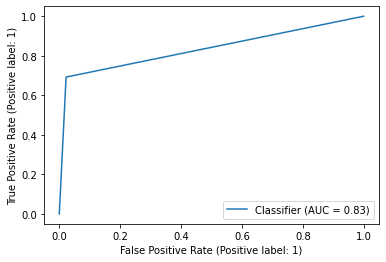

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


RocCurveDisplay.from_predictions(df['actual'], df['pred'])
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


print('AUC: ',roc_auc_score(df['actual'], df['pred']))
print('Accuracy: ',accuracy_score(df['actual'], df['pred']))
print('f1: ',f1_score(df['actual'], df['pred']))


AUC:  0.8349875930521092
Accuracy:  0.96875
f1:  0.5806451612903226
